# AnnexinV and PI Incucyte Analysis
- *Bel Taylor-Hearn, 2024*
- Experimental data generated by Marcus Preedy

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os

from tifffile import imread

import pathlib
import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm

import skimage
from skimage import color
from skimage import io
from skimage.measure import label, regionprops, regionprops_table

import napari
from PIL import Image
from cellpose import plot
from cellpose import models, utils, io

from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings("ignore")


In [ ]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Enables parallel jobs to run and display of a tqdm progress bar.

    Parameters:
    -----------
    tqdm_object : tqdm
        The tqdm progress bar instance to be updated.

    """
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_sise)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [ ]:
def cellpose_live_segmentation(path):
    """
    Perform segmentation of a single timestep 2D image using a pretrained Cellpose model.

    Parameters:
    -----------
    path : str
        File path to the input image.

    Returns:
    --------
    masks : np.ndarray
        Segmentation mask array with unique integer labels for each detected object (e.g., cell).
    """
    img = io.imread(path)
    model = models.CellposeModel(pretrained_model="C:\\Users\\isobe\\Dropbox (The University of Manchester)\\Python\\Data_For_Others\\Marcus\\Cellpose_good_model") 
    masks, flows, styles= model.eval(img, diameter=None, channels=[0,0])
    return masks

In [ ]:
def find_brightness_in_cell (frame, label, originals_pi, originals_av, trackmate_labels, n_mean = 20):
    """
    Quantify total and peak (average of top n_mean brightest pixels within the cell) fluorescence intensity of two channels (PI and AV) within a segmented cell.
        - Mean of the brightest pixels (`mean_av` and `mean_pi`) captures peak signal intensity, useful for detecting early apoptosis or membrane permeability.
    This later allows you to quantify AV- or PI-positive cells based on bright dots of protein, or total protein in the cell

    Parameters:
    -----------
    frame : int
        The timepoint index to analyze.

    label : int
        The unique label of the cell (from a labeled segmentation mask) to extract signal from.

    originals_pi : np.ndarray
        A 3D array (T, Y, X) of fluorescence signal for the PI channel.

    originals_av : np.ndarray
        A 3D array (T, Y, X) of fluorescence signal for the AV channel.

    trackmate_labels : np.ndarray
        A 3D label array (T, Y, X) from segmentation (e.g. from TrackMate), where each unique value corresponds to a distinct cell or object (linked between frames).

    n_mean : int, optional (default=20)
        The number of brightest pixels within the cell to average for computing peak intensity.

    Returns:
    --------
    list of float
        A list containing:
            - `amount_of_av` : total Annexin V intensity within the cell
            - `amount_of_pi` : total PI intensity within the cell
            - `mean_av` : mean of the `n_mean` brightest AV pixels in the cell
            - `mean_pi` : mean of the `n_mean` brightest PI pixels in the cell
    """
    amount_of_av = (originals_av[frame,:,:] * (trackmate_labels[frame,:,:]==label)).sum()
    amount_of_pi = (originals_pi[frame,:,:] * (trackmate_labels[frame,:,:]==label)).sum()

    mean_av = np.mean(np.sort((originals_av[frame,:,:] * (trackmate_labels[frame,:,:]==label)).flatten())[::-1][:n_mean])
    mean_pi = np.mean(np.sort((originals_pi[frame,:,:] * (trackmate_labels[frame,:,:]==label)).flatten())[::-1][:n_mean])
    # amount of av + amount of pi = TOTAL amount of the protein in each cell
    # mean av and mean pi = MEAN of n_mean brightest pixels in the cell
    return [amount_of_av, amount_of_pi, mean_av, mean_pi]

In [ ]:
def calculate_brightnesses_in_each_cell(identifier, trackmate_labels, originals_pi, originals_av):
    """
    Calculates total and mean AV/PI brightness values for each labeled cell across all time frames.

    For each frame, this function:
    - Identifies all segmented cells in `trackmate_labels`.
    - Computes total and mean brightness values for both AV and PI channels using `find_brightness_in_cell`.
    - Records area, frame number, and brightness features for each cell.

    Parameters:
    -----------
    identifier : str
        Identifier used to name the output CSV file containing brightness measurements.
    trackmate_labels : np.ndarray
        3D label array of shape (T, Y, X), where each time frame contains uniquely labeled cells
        (e.g., output from TrackMate or a segmentation pipeline).
    originals_pi : np.ndarray
        3D array of grayscale PI images with shape (T, Y, X), representing PI (red) channel.
    originals_av : np.ndarray
        3D array of grayscale AV images with shape (T, Y, X), representing Annexin V (green) channel.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with one row per cell per frame, containing:
        - label: Cell label ID
        - area: Pixel area of the cell
        - amount_av: Total AV signal intensity within the cell
        - amount_pi: Total PI signal intensity within the cell
        - mean_av: Mean intensity of the n brightest AV pixels in the cell
        - mean_pi: Mean intensity of the n brightest PI pixels in the cell
        - frame: Frame index

    Notes:
    ------
    - The function saves the result as a CSV file named "<identifier>_output.csv", where "identifier" is unique for the experiment
    """
    all_props = []
    for frame in range(trackmate_labels.shape[0]):
        props = pd.DataFrame(regionprops_table(trackmate_labels[frame,:,:], properties =("label", "area")))
        props["amount_av"] = props.apply(lambda x: find_brightness_in_cell(frame, x.label, originals_pi, originals_av, trackmate_labels), axis=1).str[0]
        props["amount_pi"] = props.apply(lambda x: find_brightness_in_cell(frame, x.label, originals_pi, originals_av, trackmate_labels), axis=1).str[1]
        props["mean_av"] = props.apply(lambda x: find_brightness_in_cell(frame, x.label, originals_pi, originals_av, trackmate_labels), axis=1).str[2]
        props["mean_pi"] = props.apply(lambda x: find_brightness_in_cell(frame, x.label, originals_pi, originals_av, trackmate_labels), axis=1).str[3]
        props["frame"] = frame
        all_props.append(props)
    all_props = pd.concat(all_props)
    all_props.to_csv("{}_output.csv".format(identifier))
    return all_props

In [ ]:
def calculate_positive_labels(frame, column, cutoff, all_props, trackmate_labels):
    """
    Generates a binary label mask for cells in a given frame that exceed a specified measurement cutoff.

    Parameters:
    -----------
    frame : int
        Index of the time frame to analyze.
    column : str
        Name of the column in `all_props` to apply the cutoff (e.g., 'amount_av', 'mean_pi').
    cutoff : float
        Threshold value above which a cell is considered "positive".
    all_props : pd.DataFrame
        DataFrame containing per-cell properties, including 'label', 'frame', and the specified `column`.
        Typically generated by `calculate_brightnesses_in_each_cell`.
    trackmate_labels : np.ndarray
        3D array of shape (T, Y, X) with labeled cell masks per frame.

    Returns:
    --------
    np.ndarray
        2D array of shape (Y, X) for the specified `frame`, where pixels belonging to "positive" cells
        retain their original label values, and all other pixels are set to 0.
    """
    positive_cells = all_props[((all_props["frame"]==frame) & (all_props[column]>= cutoff))].label.unique()
    mask = np.isin(trackmate_labels[frame,:,:], positive_cells)
    positive_cells = np.where(mask, trackmate_labels[frame,:,:], 0)
    return positive_cells

In [ ]:
def plot_frame_and_positive_cells(frame, mean_or_total, pi_threshold, av_threshold, all_props, originals_bf, originals_av, originals_pi, trackmate_labels):
    """
    Visualises a given time frame of imaging data along with AV/PI channel intensities
    and overlays of segmented cells that exceed user-defined intensity thresholds.

    Parameters:
    -----------
    frame : int
        Time frame index to visualise.
    mean_or_total : str
        Determines whether to use "mean" or "total" intensity values for thresholding.
        Must be either "mean" (uses 'mean_av' and 'mean_pi') or anything else (uses 'amount_av' and 'amount_pi').
    pi_threshold : float
        Threshold for PI intensity (either mean or total depending on `mean_or_total`).
    av_threshold : float
        Threshold for AV intensity (either mean or total depending on `mean_or_total`).
    all_props : pd.DataFrame
        DataFrame containing per-cell measurements per frame (as returned by `calculate_brightnesses_in_each_cell`),
        with required columns: 'frame', 'label', 'amount_pi', 'amount_av', 'mean_pi', 'mean_av'.
    originals_bf : np.ndarray
        3D array of brightfield images with shape (T, Y, X).
    originals_av : np.ndarray
        3D array of AV grayscale images with shape (T, Y, X).
    originals_pi : np.ndarray
        3D array of PI grayscale images with shape (T, Y, X).
    trackmate_labels : np.ndarray
        3D array of labeled cell segmentations with shape (T, Y, X),
        where each unique integer represents a cell.

    Displays:
    ---------
    A 6-panel figure showing:
    1. Brightfield image for the selected frame.
    2. AV channel image.
    3. PI channel image.
    4. Brightfield with all segmented cells overlaid and labeled.
    5. Cells positive for PI (above threshold) overlaid.
    6. Cells positive for AV (above threshold) overlaid.

    Notes:
    ------
    - Uses `np.isin` to determine which labeled cells exceed the threshold.
    - Sets non-target regions to `NaN` to ensure clean overlay visualization.
    - Cell labels are annotated using `regionprops`.
    - Axes are turned off and titled appropriately.
    """
    fig, ax = plt.subplots(ncols = 6, figsize=(20,15))
    ax[0].imshow(originals_bf[frame,:,:])
    ax[1].imshow(originals_av[frame,:,:], cmap = "gray")
    ax[2].imshow(originals_pi[frame,:,:], cmap = "gray")

    test = trackmate_labels[frame,:,:].astype(float)
    test[test ==0] = np.nan
    ax[3].imshow(originals_bf[frame,:,:])
    ax[3].imshow(test)
    for region in (regionprops(trackmate_labels[frame,:,:])):
        ax[3].text(x = region.centroid[1], y = region.centroid[0], s=region.label, color = "black", fontsize = "xx-small", fontweight="bold")

    test = trackmate_labels[frame,:,:]

    if mean_or_total.lower() == "mean":
        pi_cells = all_props[((all_props["frame"]==frame) & (all_props["mean_pi"]>= pi_threshold))].label.unique()
        av_cells = all_props[((all_props["frame"]==frame) & (all_props["mean_av"]>= av_threshold))].label.unique()
    else:
        pi_cells = all_props[((all_props["frame"]==frame) & (all_props["amount_pi"]>= pi_threshold))].label.unique()
        av_cells = all_props[((all_props["frame"]==frame) & (all_props["amount_av"]>= av_threshold))].label.unique()

    mask = np.isin(test, pi_cells)
    pi_cells = np.where(mask, test, 0).astype(float)
    pi_cells[pi_cells ==0] = np.nan
    ax[4].imshow(pi_cells)

    mask = np.isin(test, av_cells)
    av_cells = np.where(mask, test, 0).astype(float)
    av_cells[av_cells ==0] = np.nan
    ax[5].imshow(av_cells)

    column_titles = ["BF", "AV", "PI", "All Cells", "PI Cells", "AV Cells"]
    for i, a in enumerate(ax):
        a.axis("off")
        a.set_title(column_titles[i])

In [ ]:
def quantify_death(identifier, n_timesteps, mean_or_total, pi_threshold, av_threshold, percentage_of_frames_appeared_in, all_props):
    """
    Quantifies cell death over time based on defined AV and PI intensity thresholds.

    This function tracks cells that appear consistently across multiple frames and classifies them as
    apoptotic or necroptotic and generates visual and CSV output of death progression across time.

    Parameters:
    -----------
    identifier : str
        Prefix for naming output files (plots and CSVs).
    n_timesteps : int
        Total number of timepoints/frames in the dataset.
    mean_or_total : str
        Metric used for thresholding: "mean" to use `mean_av`/`mean_pi`, anything else uses `total_av`/`total_pi`.
    pi_threshold : float
        Threshold for PI signal (mean or total).
    av_threshold : float
        Threshold for Annexin V signal (mean or total).
    percentage_of_frames_appeared_in : float
        Minimum percentage of frames a cell must appear in to be considered a "long track".
    all_props : pd.DataFrame
        DataFrame with per-cell brightness metrics and metadata (from `calculate_brightnesses_in_each_cell`),
        must include columns: 'label', 'frame', 'mean_av', 'mean_pi', 'total_av', 'total_pi'.

    Returns:
    --------
    tuple
        - av_cells : list of int
            Unique labels of cells classified as Annexin V-positive (apoptotic).
        - pi_cells : list of int
            Unique labels of cells classified as PI-only positive (necrotic).
        - number_av : list of int
            Number of apoptotic (AV+) cells at each frame.
        - number_pi : list of int
            Number of necrotic (PI-only) cells at each frame.
        - number_of_long_tracks : int
            Total number of cells tracked for sufficient time (long tracks).

    Outputs:
    --------
    - A line plot showing % of AV+, PI-only, and total dead cells over time (`identifier_output.pdf`).
    - CSV of all qualifying long-track cells (`{identifier}_longtracksonly_{percentage}.csv`).
    - Minimal CSV with counts per timepoint (`{identifier}minimal_output{percentage}.csv`).

    Notes:
    ------
    - A cell is classified as apoptotic (green/AV+) if it passes the AV threshold at any timepoint.
    - A cell is classified as necrotic (red/PI-only) if it passes the PI threshold but hasn't previously been identified as apoptotic.
    - Cells must appear in more than a specified percentage of frames to be included in the analysis.
    """
    filtered_props = all_props[all_props.groupby("label").transform('size')>(n_timesteps*(percentage_of_frames_appeared_in/100))]
    number_of_long_tracks = len(filtered_props.label.unique())
    av_cells = []
    pi_cells = []
    number_av = []
    number_pi = []
    for frame in range(n_timesteps):
        if mean_or_total.lower() == "mean":
            cells_above_pi_threshold = filtered_props[((filtered_props["frame"]==frame) & (filtered_props["mean_pi"]>= pi_threshold))].label.unique()
            cells_above_av_threshold = filtered_props[((filtered_props["frame"]==frame) & (filtered_props["mean_av"]>= av_threshold))].label.unique()
        else:
            cells_above_pi_threshold = filtered_props[((filtered_props["frame"]==frame) & (filtered_props["total_pi"]>= pi_threshold))].label.unique()
            cells_above_av_threshold = filtered_props[((filtered_props["frame"]==frame) & (filtered_props["total_av"]>= av_threshold))].label.unique()
        # if it's green only -> add to apoptosis cells
        for cell_label in cells_above_av_threshold:
            if cell_label not in av_cells:
                av_cells.append(cell_label)
        # if it's red only and hasn't previously been green -> add to necroptosis cells 
        for cell_label in cells_above_pi_threshold:
            if cell_label not in av_cells and cell_label not in pi_cells:
                pi_cells.append(cell_label)
        number_of_av_cells = len(av_cells)
        number_of_pi_cells = len(pi_cells)
        number_av.append(number_of_av_cells)
        number_pi.append(number_of_pi_cells)

    percentage_of_av_cells_at_each_time = [(100* count/number_of_long_tracks) for count in number_av]
    percentage_of_pi_cells_at_each_time = [(100* count/number_of_long_tracks) for count in number_pi]
    total_percentage_dead = [(percentage_of_av_cells_at_each_time[i] + percentage_of_pi_cells_at_each_time[i]) for i in range(len(percentage_of_av_cells_at_each_time))]

    fig, ax = plt.subplots()
    sns.lineplot(x=np.arange(n_timesteps), y= percentage_of_av_cells_at_each_time, color="green", label="AnnexinV")
    sns.lineplot(x=np.arange(n_timesteps), y= percentage_of_pi_cells_at_each_time, color="red", label="PI Only")
    sns.lineplot(x=np.arange(n_timesteps), y= total_percentage_dead, color="black", label="Total Death")

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Frame")
    ax.set_ylabel("% Dead")
    ax.set_ylim(0,100)
    ax.set_title(identifier)
    filtered_props.to_csv("{}_longtracksonly_{}.csv".format(identifier, percentage_of_frames_appeared_in))
    plt.savefig("{}_output.pdf".format(identifier), bbox_inches="tight", transparent=False)
    minimal_output = pd.DataFrame({ 'number_av': number_av, 'number_pi': number_pi})
    minimal_output["number_of_long_tracks"] = number_of_long_tracks
    minimal_output.to_csv("{}minimal_output{}.csv".format(identifier, percentage_of_frames_appeared_in))

    return av_cells, pi_cells, number_av, number_pi, number_of_long_tracks    

In [ ]:
def generate_originals_and_cellpose_labels(base_root, sub_roots):
    """
    Loads brightfield, Annexin V, and PI image stacks from multiple subdirectories,
    converts PI and AV images to grayscale, saves them as TIFF stacks, and generates
    segmentation labels from brightfield images using Cellpose.

    Parameters:
    -----------
    base_root : str
        The root directory containing all experimental subdirectories.
    sub_roots : list of str
        List of relative subdirectory paths (e.g., one per experiment or condition)
        under `base_root`, each expected to contain 'Brightfield', 'AnnexinV', and 'PI' folders.

    Workflow:
    ---------
    For each `sub_root`:
    - Loads `.tif` images from 'Brightfield', 'AnnexinV', and 'PI' folders.
    - Converts PI and AV images to grayscale using `skimage.color.rgb2gray`.
    - Stacks and saves:
        * PI grayscale images -> `*_pi.tiff`
        * AV grayscale images -> `*_av.tiff`
        * Brightfield originals -> `*_originals.tiff`
    - Applies `cellpose_live_segmentation()` on each brightfield image.
        * Stacks resulting label masks -> `*_cellpose_labels.tiff`

    Output TIFFs are saved in the current directory with names derived from the input
    path (cleaned of backslashes, spaces, and drive names like 'E:Marcus').

    Notes:
    ------
    - Assumes each subdirectory contains a matching number of timepoints for all channels.
    - The function prints the path being processed and the number of files loaded for each channel.
    - Requires `cellpose_live_segmentation()` to be defined elsewhere in the codebase.
    """
    for sub_root in sub_roots:
        root = base_root + sub_root
        print(root)
        bf_root = root + "\\Brightfield"
        aV_root = root + "\\AnnexinV"
        PI_root = root + "\\PI"
        bf_paths = list(pathlib.Path(bf_root).glob("**/*.tif"))
        aV_paths = list(pathlib.Path(aV_root).glob("**/*.tif"))
        pi_paths = list(pathlib.Path(PI_root).glob("**/*.tif"))
        originals_pi = np.stack([color.rgb2gray(imread(path)) for path in pi_paths], axis=0)
        originals_av = np.stack([color.rgb2gray(imread(path)) for path in aV_paths], axis=0)
        skimage.io.imsave("{}_pi.tiff".format(root.replace("\\", "").replace("E:Marcus", "").replace(" ","")), originals_pi)
        skimage.io.imsave("{}_av.tiff".format(root.replace("\\", "").replace("E:Marcus", "").replace(" ","")), originals_av)

        print(len(bf_paths), len(aV_paths), len(pi_paths))
        originals_bf = np.stack([imread(path) for path in bf_paths], axis=0)
        skimage.io.imsave("{}_originals.tiff".format(root.replace("\\", "").replace("E:Marcus", "").replace(" ","")), originals_bf)
        labels = np.stack([cellpose_live_segmentation(path) for path in bf_paths], axis=0)
        skimage.io.imsave("{}_cellpose_labels.tiff".format(root.replace("\\", "").replace("E:Marcus", "").replace(" ","")), labels)

In [ ]:
def extract_treatment(filename):
    """
    Extracts the treatment group identifier from a filename based on known prefix patterns,
    handling case insensitivity and variable file extension lengths.

    Parameters:
    -----------
    filename : str
        Full filename including extension (e.g., 'shContvsshXPO5_Treatment1.TIF').

    Returns:
    --------
    str
        The extracted treatment group name based on the filename pattern:
        - If filename starts with 'shContvsshXPO5', returns the portion after that prefix (excluding extension).
        - If filename starts with 'WTBvsTvsBT', returns the portion after that prefix (excluding extension).
        - Returns 'Unknown' if the filename doesn't match any known prefix.

    Notes:
    ------
    - Matching is case-insensitive.
    - File extensions of any length are handled via `os.path.splitext`.
    - To add more patterns, extend the `prefixes` dictionary.
    """
    name, _ = os.path.splitext(filename)
    name_lower = name.lower()

    prefixes = {
        'shcontvsshxpo5': len('shcontvsshxpo5'),
        'wtbvstvsbt': len('wtbvstvsbt'), #add more experimental choices here if needed
    }

    for prefix, prefix_len in prefixes.items():
        if name_lower.startswith(prefix):
            return name[prefix_len:]

    return 'Unknown'

In [ ]:
generate_originals_and_cellpose_labels("C:\\Users\\isobe\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Python\\Data_For_Others\\Marcus\\extra_files\\",["Brightfield Part 1"])

C:\Users\isobe\The University of Manchester Dropbox\Isobel Taylor-Hearn\Python\Data_For_Others\Marcus\extra_files\Brightfield Part 1
50 50 50


Move to FIJI/ImageJ to Link Frames
- At this stage you have generated unlinked labels(!)
- To link the labels between frames, run TrackMate in FIJI/ImageJ
- Export the resultant label image and save it in a folder called "trackmate_labels" (or update the path in the cell below)

In [ ]:
trackmate_paths = list(pathlib.Path(".\\extra_files\\Brightfield Part 1\\trackmate_labels").glob("**/*.tif"))
av_paths = list(pathlib.Path(".\\extra_files\\Brightfield Part 1\\av").glob("**/*.tiff"))
pi_paths = list(pathlib.Path(".\\extra_files\\Brightfield Part 1\\pi").glob("**/*.tiff"))
bf_paths = list(pathlib.Path(".\\extra_files\\Brightfield Part 1\\originals").glob("**/*.tiff"))

with tqdm_joblib(tqdm(desc="Image Analysis", total=len(trackmate_paths))) as progress_bar:
    output = Parallel(n_jobs=-2)(delayed(calculate_brightnesses_in_each_cell)(str(pi_paths[i]).replace(".tiff", "").split("\\")[1], imread(trackmate_paths[i]), imread(pi_paths[i]), imread(av_paths[i])) for i in range(len(trackmate_paths)))

Image Analysis: 100%|██████████| 1/1 [26:31<00:00, 1591.92s/it]


In [ ]:
av_total_cutoff = 120
pi_total_cutoff = 80
av_mean_cutoff = 0.7
pi_mean_cutoff = 0.3

#~~~~~~~~~UNHASH IF YOU WANT TO CHANGE THE CUTOFFS OR VIEW THE LABELS #########
# av_labels = np.stack([calculate_positive_labels(frame, "amount_av", av_total_cutoff, all_props, trackmate_labels) for frame in range(trackmate_labels.shape[0])], axis=0)
# pi_labels = np.stack([calculate_positive_labels(frame, "amount_pi", pi_total_cutoff, all_props, trackmate_labels) for frame in range(trackmate_labels.shape[0])], axis=0)

# av_mean_labels = np.stack([calculate_positive_labels(frame, "mean_av", av_mean_cutoff, all_props, trackmate_labels) for frame in range(trackmate_labels.shape[0])], axis=0)
# pi_mean_labels = np.stack([calculate_positive_labels(frame, "mean_pi", pi_mean_cutoff, all_props, trackmate_labels) for frame in range(trackmate_labels.shape[0])], axis=0)
# plot_frame_and_positive_cells(10, "mean", pi_threshold=pi_mean_cutoff, av_threshold=av_mean_cutoff, all_props=all_props, originals_bf =originals_bf, originals_av=originals_av, originals_pi=originals_pi, trackmate_labels=trackmate_labels)

# viewer = napari.Viewer()
# # viewer.add_image(originals_bf)
# # viewer.add_image(originals_av)
# # viewer.add_image(originals_pi)
# viewer.add_labels(av_mean_labels)
# viewer.add_labels(pi_mean_labels)
# viewer.add_labels(av_labels)
# viewer.add_labels(pi_mean_labels)

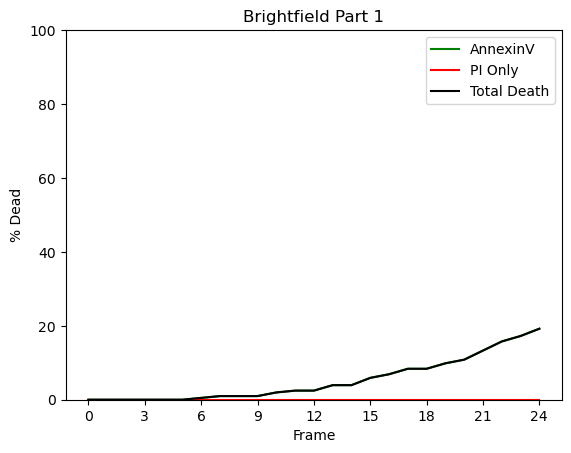

In [ ]:
folder_containing_outputs = ".\\extra_files\\Brightfield Part 1\\segmentation_output"
all_output_paths = list(pathlib.Path(folder_containing_outputs).glob("**/*.csv"))
for i, path in enumerate(all_output_paths):
    av_cells, pi_cells, number_av, number_pi, number_of_long_tracks  = quantify_death((str(all_output_paths[i])).split("\\")[-1].replace("_output.csv",""), 25, "mean", pi_mean_cutoff, av_mean_cutoff, 50, pd.read_csv(path))


In [ ]:
folder_containing_filtered_outputs = "C:\\Users\\isobe\\Dropbox (The University of Manchester)\\Python\Data_For_Others\\Marcus\\minimal_output"
all_output_paths = list(pathlib.Path(folder_containing_filtered_outputs).glob("**/*.csv"))
total_data = []
for path in all_output_paths:
    data = (pd.read_csv(path))
    data["filename"] = str(path).split("\\")[-1].replace("minimal_output50.csv","")
    total_data.append(data)
total_data = pd.concat(total_data)
total_data["experiment_id"] = total_data["filename"].apply(lambda x: x[-4:])
total_data['experiment'] = total_data['filename'].apply(lambda x: 'shContvsshXPO5' if x.startswith('shContvsshXPO5') else 'WTBvsTvsBT' if x.startswith('WTBvsTvsBT') else 'Other')
total_data['treatment'] = total_data['filename'].apply(extract_treatment)

## Plot Average Data

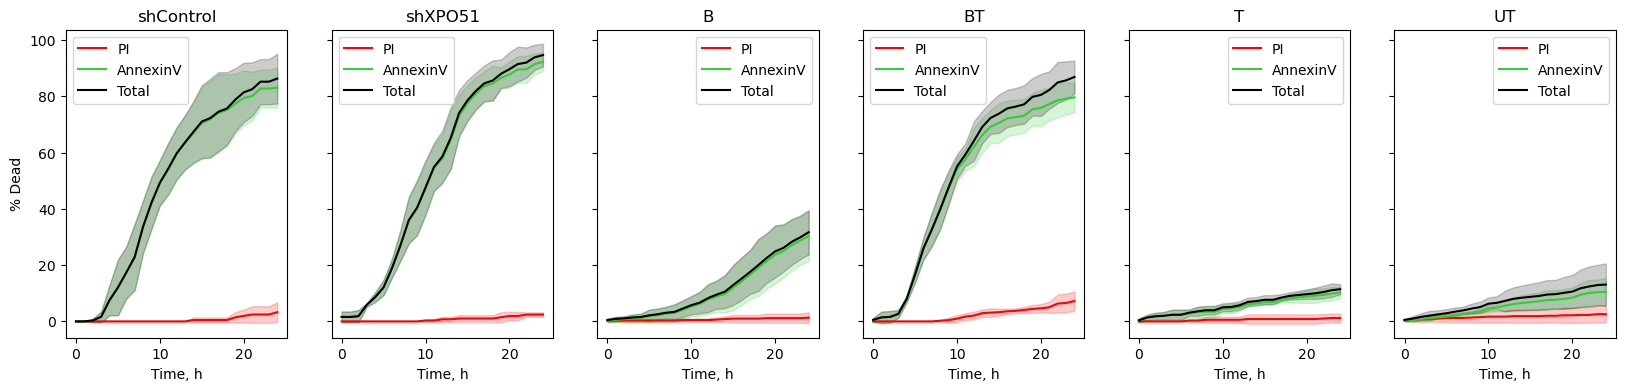

In [ ]:
fig, ax = plt.subplots(ncols = len(total_data["treatment"].unique()), figsize=(20,4), sharey=True)
for i, treatment in enumerate(total_data["treatment"].unique()):
    data_to_plot = total_data[total_data["treatment"]==treatment]
    data_to_plot["%_dead_av"] = (data_to_plot["number_av"]/data_to_plot["number_of_long_tracks"])*100
    data_to_plot["%_dead_pi"] = (data_to_plot["number_pi"]/data_to_plot["number_of_long_tracks"])*100
    data_to_plot["%_dead"] = data_to_plot["%_dead_pi"] + data_to_plot["%_dead_av"]
    sns.lineplot(data = data_to_plot, x="Unnamed: 0", y="%_dead_pi",  ax=ax[i], color="red", errorbar=('sd'), label="PI")
    sns.lineplot(data = data_to_plot, x="Unnamed: 0", y="%_dead_av",  ax=ax[i], color="limegreen", errorbar=('sd'), label="AnnexinV")
    sns.lineplot(data = data_to_plot, x="Unnamed: 0", y="%_dead",  ax=ax[i], color="black", errorbar=('sd'), label="Total")
    ax[i].set_xlabel("Time, h")
    ax[i].set_ylabel("% Dead") 
    ax[i].set_title(treatment)
plt.savefig("Marcus_outputs.pdf", bbox_inches="tight", transparent=True)

## Plot All Experimental Data Separately

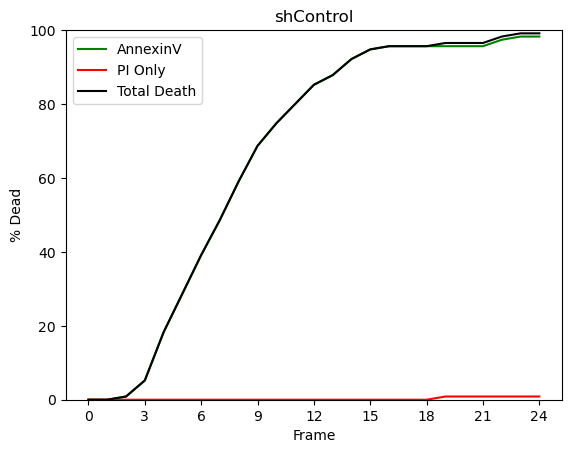

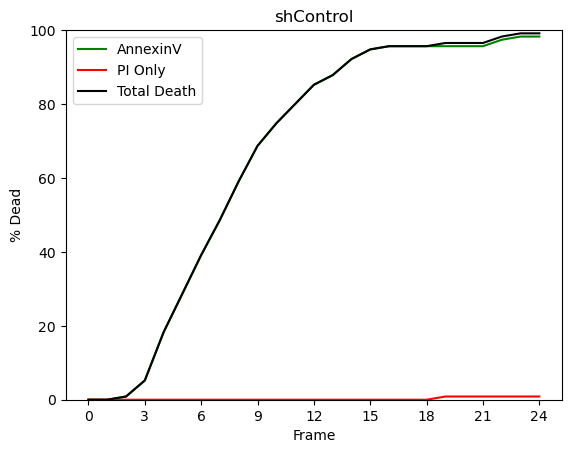

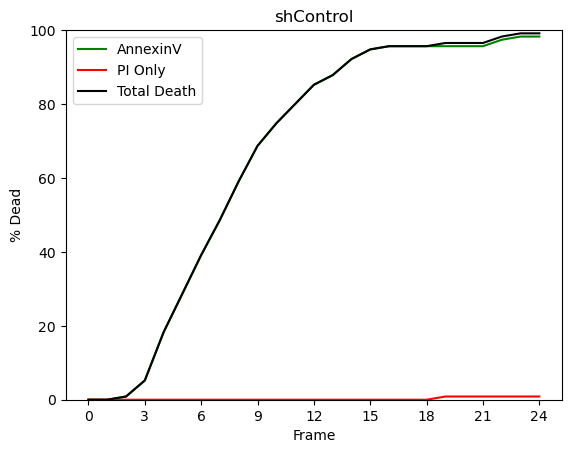

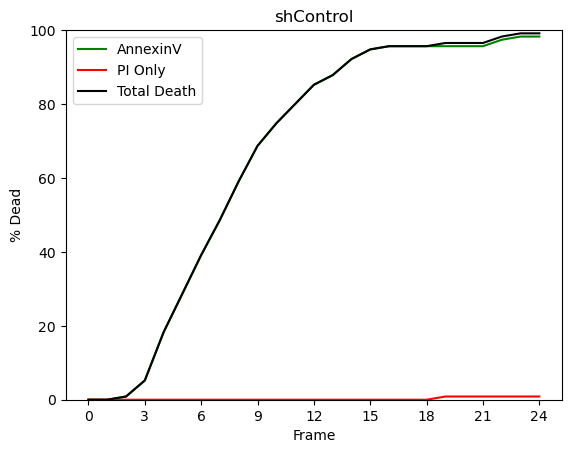

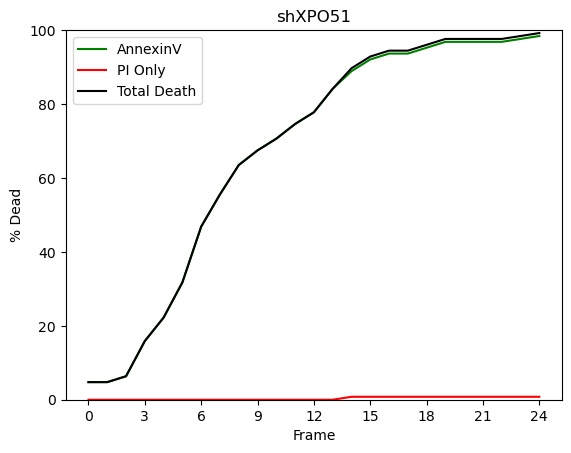

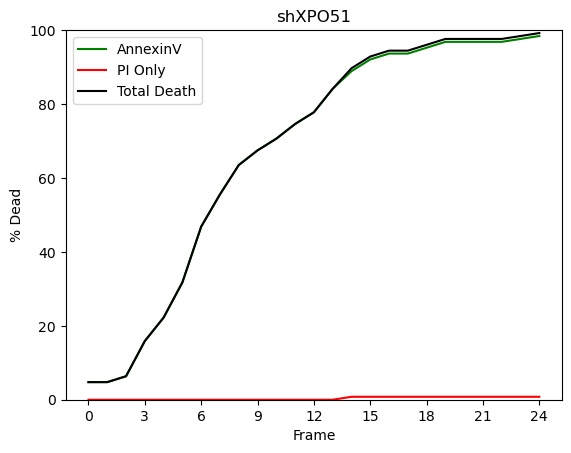

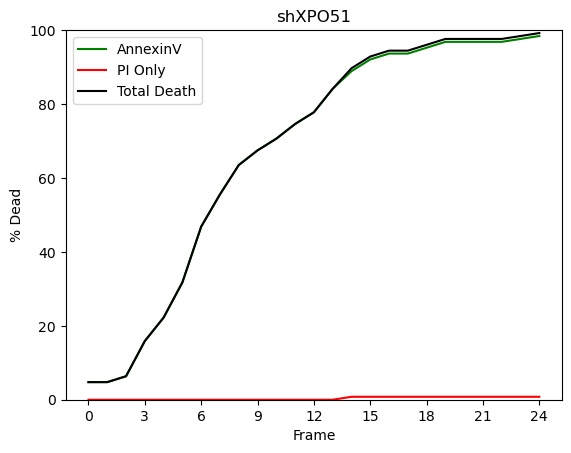

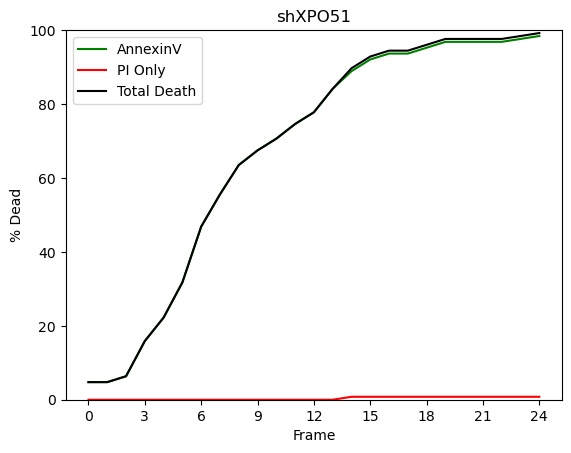

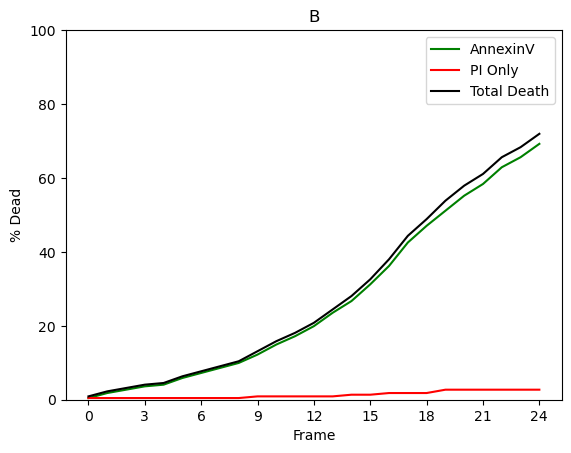

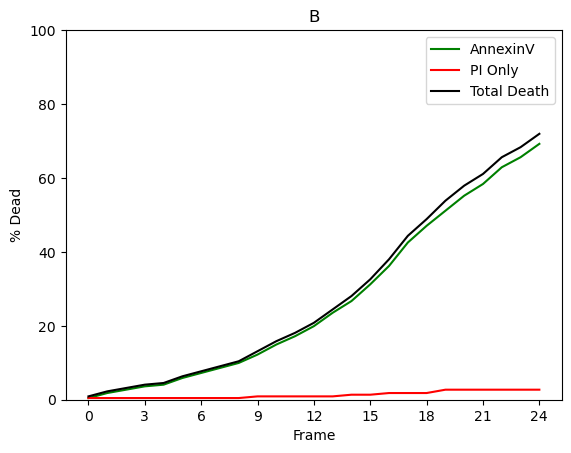

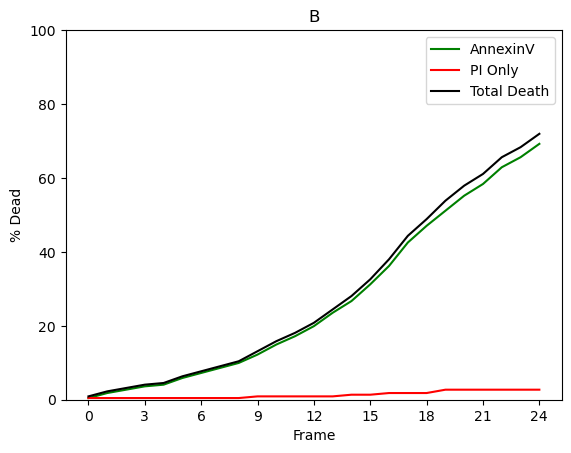

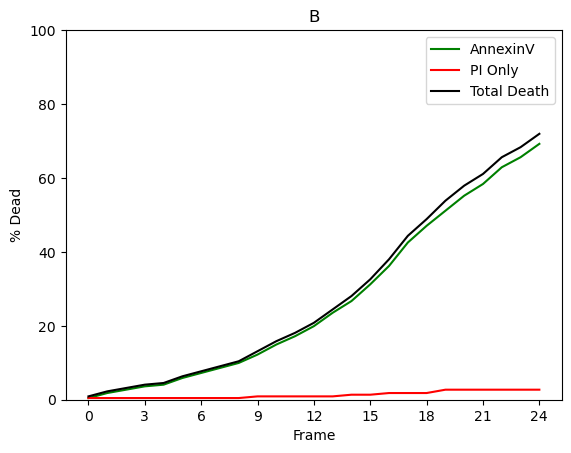

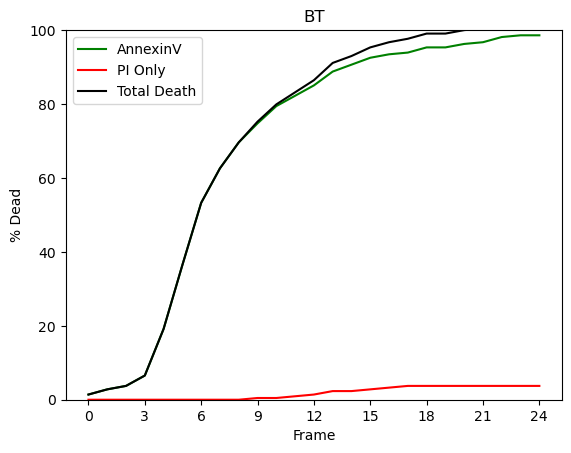

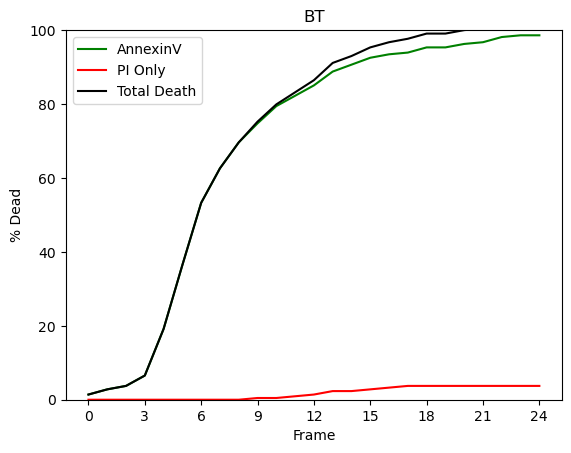

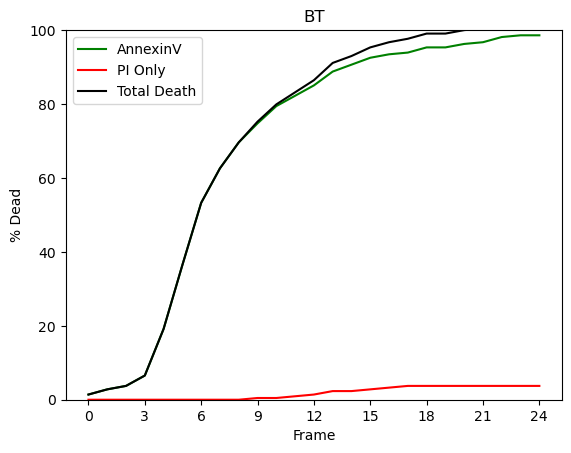

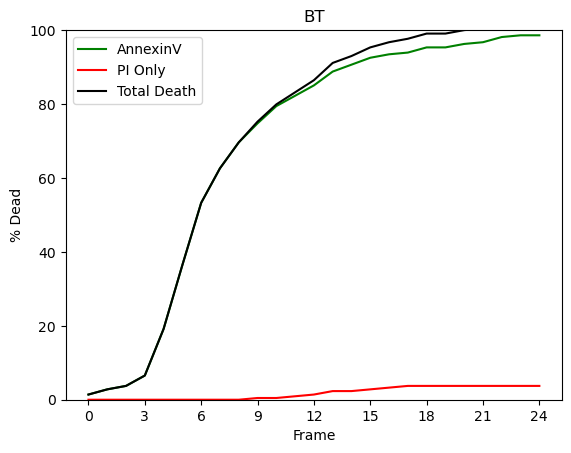

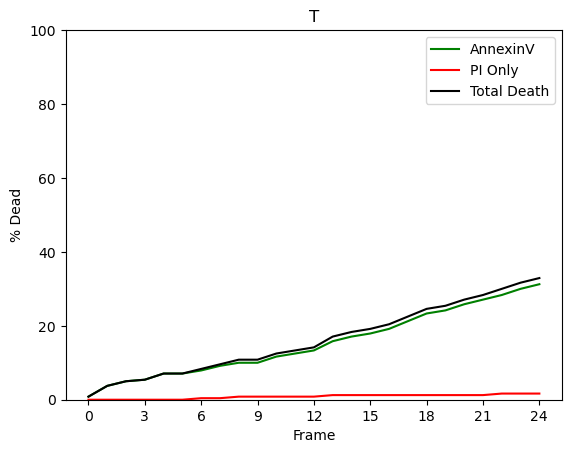

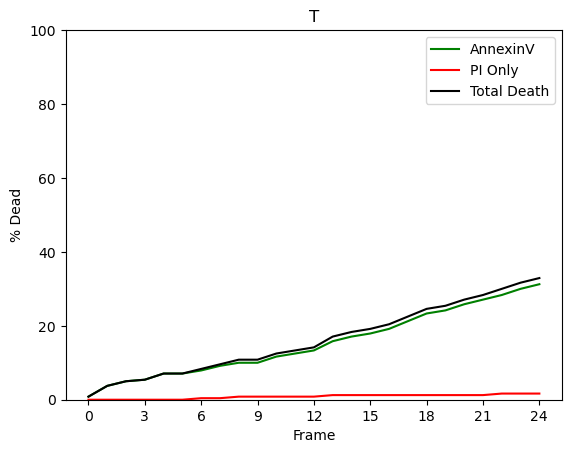

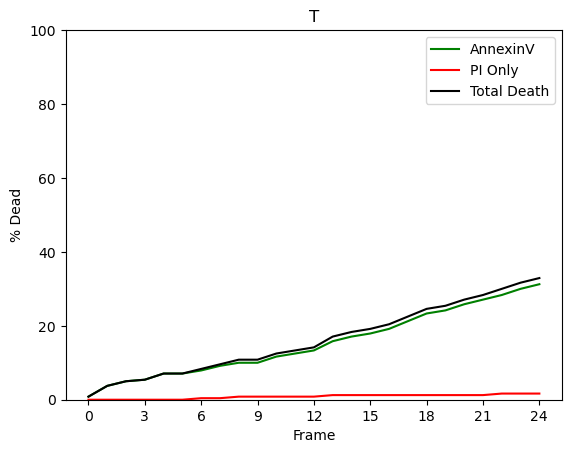

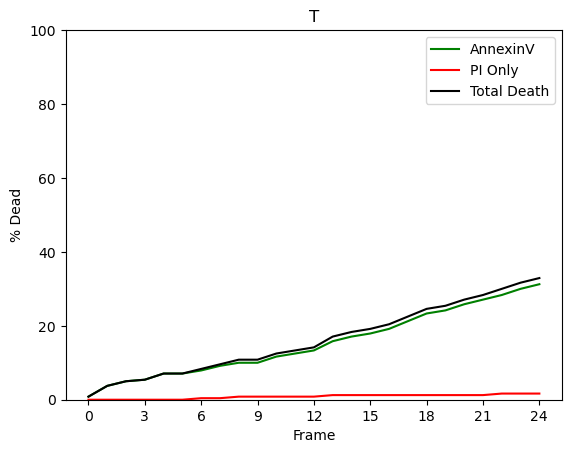

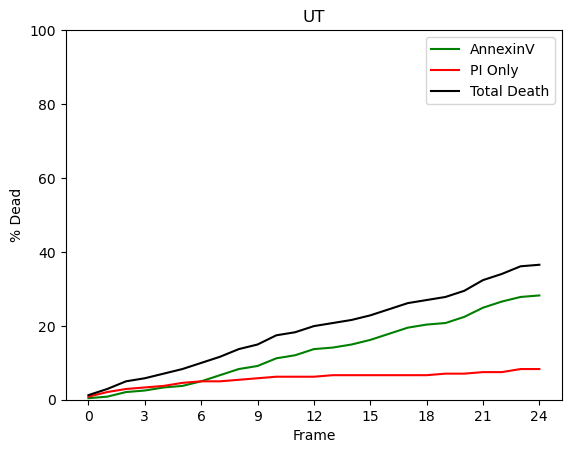

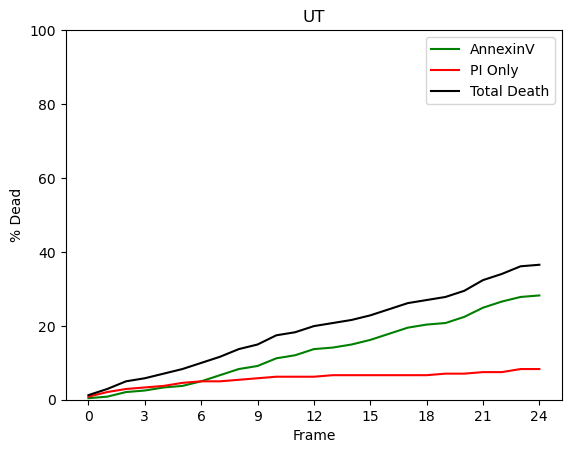

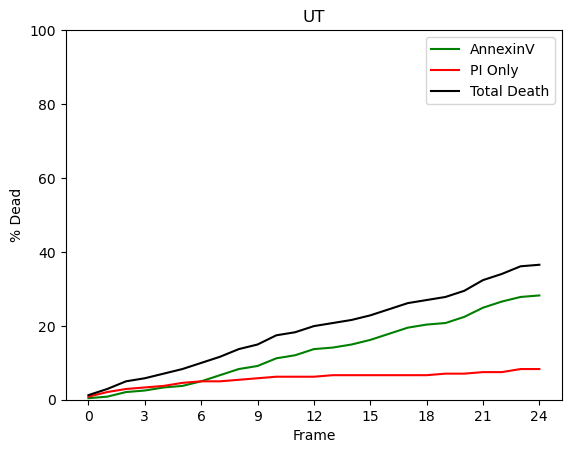

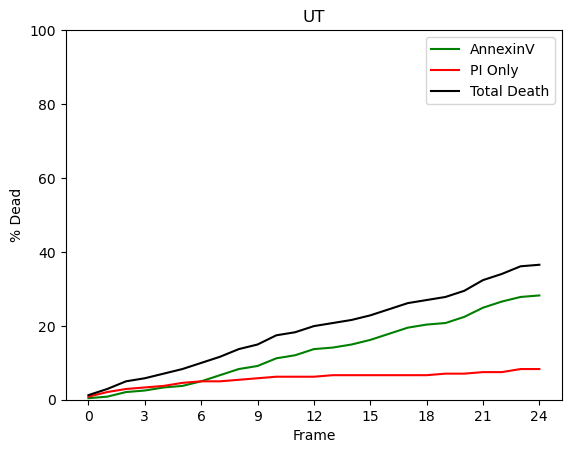

In [ ]:
for treatment in total_data.treatment.unique():
    data_to_plot = total_data[total_data["treatment"]==treatment]
    #fig, ax = plt.subplots()
    for experiment_id in data_to_plot.experiment_id.unique():
        quantify_death(treatment, 25, "mean", pi_mean_cutoff, av_mean_cutoff, 50, data_to_plot)